In [1]:
# Import Packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
import sys
import dtale
# import holidays

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

%matplotlib inline


# Folder Structure
SCRIPT_DIR = (os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(os.path.dirname(SCRIPT_DIR), "data")

# Read Data
train = pd.read_csv(f"{DATA_DIR}/train_BRCpofr.csv")
test = pd.read_csv(f"{DATA_DIR}/test_koRSKBP.csv")

print(train.shape, test.shape)
train.sample()

(89392, 12) (59595, 11)


,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
88595,88596,Male,Urban,Bachelor,2L-5L,0,6,4106,More than 1,B,Platinum,68388


<AxesSubplot:>

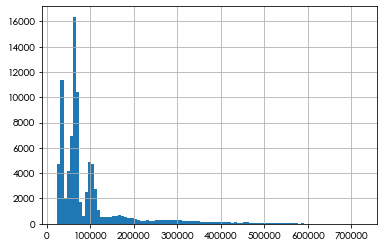

In [2]:
train['cltv'].hist(bins=100)

In [3]:
test.sample()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
2957,92350,Female,Urban,Bachelor,2L-5L,1,1,3057,1,B,Platinum


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              89392 non-null  int64 
 1   gender          89392 non-null  object
 2   area            89392 non-null  object
 3   qualification   89392 non-null  object
 4   income          89392 non-null  object
 5   marital_status  89392 non-null  int64 
 6   vintage         89392 non-null  int64 
 7   claim_amount    89392 non-null  int64 
 8   num_policies    89392 non-null  object
 9   policy          89392 non-null  object
 10  type_of_policy  89392 non-null  object
 11  cltv            89392 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 8.2+ MB


In [5]:
train['type_of_policy'].value_counts()

Platinum    47796
Silver      21010
Gold        20586
Name: type_of_policy, dtype: int64

In [6]:
for df in [train, test]:
    df.loc[(df['income'] == "5L-10L"), "min_income"] = 5
    df.loc[(df['income'] == "5L-10L"), "max_income"] = 10
    df.loc[(df['income'] == "2L-5L"), "min_income"] = 2
    df.loc[(df['income'] == "2L-5L"), "max_income"] = 5
    df.loc[(df['income'] == "<=2L"), "min_income"] = 0
    df.loc[(df['income'] == "<=2L"), "max_income"] = 2
    df.loc[(df['income'] == "More than 10L"), "min_income"] = 10
    df.loc[(df['income'] == "More than 10L"), "max_income"] = 50 # Assumption
    df['num_policies'] = df['num_policies'].map({'1': 1, 'More than 1': 2})
    df['qualification'] = df['qualification'].map({'High School': 1, 'Bachelor': 2, 'Others': 0})
    df['area'] = df['area'].map({'Rural': 0, 'Urban': 1})
    df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})
    df['policy'] = df['policy'].map({'A': 0, 'B': 1, 'C': 2})
    df['type_of_policy'] = df['type_of_policy'].map({'Silver': 0, 'Gold': 1, 'Platinum': 2})

train.sample()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv,min_income,max_income
21514,21515,1,1,2,5L-10L,1,6,4008,2,1,2,43368,5.0,10.0


In [7]:
train['num_policies'].value_counts()

2    60263
1    29129
Name: num_policies, dtype: int64

In [8]:
# Select features for training
idx = [
    'id'
]

cat_features = [
    # 'gender',
    # 'area',
    # 'qualification',
    # # 'income',
    # 'num_policies',
    # 'policy',
    # 'type_of_policy'
]

num_features = [
    'marital_status',
    'vintage',
    'claim_amount',
    'min_income',
    'max_income',
    'gender',
    'area',
    'qualification',
    'num_policies',
    'policy',
    'type_of_policy'
]

features = cat_features+num_features

target = 'cltv'

Xy = train.set_index(idx)[features + [target]]
print(Xy.shape)
Xy.sample()

(89392, 12)


,marital_status,vintage,claim_amount,min_income,max_income,gender,area,qualification,num_policies,policy,type_of_policy,cltv
id,,,,,,,,,,,,
3257,0,3,0,5.0,10.0,0,0,1,2,1,2,97236


In [9]:
# Xy['income'].value_counts()

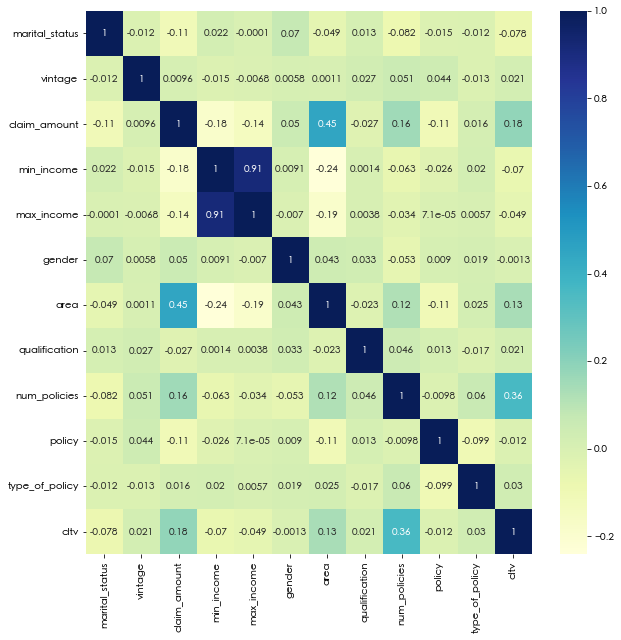

In [10]:
# Correlation plot
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(Xy.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [11]:
train_catboost = train.copy()
test_catboost = test.copy()

feature_target_mapping = {
    'idx_cols': idx,
    'num_features': num_features,
    'cat_features': cat_features,
    'target': target
}

import json
print(json.dumps(feature_target_mapping, indent=4))



for col in feature_target_mapping['cat_features']:

    train_catboost[col] = train_catboost[col].astype(str)
    test_catboost[col] = test_catboost[col].astype(str)
    
for col in feature_target_mapping['num_features']:

    train_catboost[col] = train_catboost[col].astype(float)
    test_catboost[col] = test_catboost[col].astype(float)


Xy = train_catboost[features + [target]]
X = Xy.reindex(features, axis=1)
y = Xy.reindex([target], axis=1)
print(Xy.shape)


# Random Sampling

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

{
    "idx_cols": [
        "id"
    ],
    "num_features": [
        "marital_status",
        "vintage",
        "claim_amount",
        "min_income",
        "max_income",
        "gender",
        "area",
        "qualification",
        "num_policies",
        "policy",
        "type_of_policy"
    ],
    "cat_features": [],
    "target": "cltv"
}
(89392, 12)
(50059, 11) (50059, 1) (21454, 11) (21454, 1) (17879, 11) (17879, 1)


In [12]:
# ---------------------
# Train-Val-Test Pools
# ---------------------

from catboost import Pool

# initialize Pool
full_pool = Pool(
  X,
  y,
  cat_features=feature_target_mapping['cat_features']
)

train_pool = Pool(
  X_train,
  y_train,
  cat_features=feature_target_mapping['cat_features']
)
val_pool = Pool(
  X_val,
  y_val,
  cat_features=feature_target_mapping['cat_features']
)
test_pool = Pool(
  X_test, 
  cat_features=feature_target_mapping['cat_features']
)

# Submission Pool
test_catboost_pool = Pool(
  test_catboost.reindex(features, axis=1),
  cat_features=feature_target_mapping['cat_features']
)


In [14]:
test_catboost

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,min_income,max_income
0,89393,0.0,0.0,1.0,5L-10L,0.0,6.0,2134.0,2.0,1.0,0.0,5.0,10.0
1,89394,0.0,1.0,1.0,2L-5L,0.0,4.0,4102.0,2.0,0.0,2.0,2.0,5.0
2,89395,1.0,0.0,1.0,5L-10L,1.0,7.0,2925.0,2.0,1.0,1.0,5.0,10.0
3,89396,0.0,0.0,2.0,More than 10L,1.0,2.0,0.0,2.0,1.0,0.0,10.0,50.0
4,89397,0.0,1.0,1.0,2L-5L,0.0,5.0,14059.0,2.0,1.0,0.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59590,148983,1.0,0.0,2.0,5L-10L,1.0,6.0,0.0,1.0,0.0,0.0,5.0,10.0
59591,148984,1.0,1.0,1.0,5L-10L,0.0,6.0,0.0,1.0,2.0,1.0,5.0,10.0
59592,148985,0.0,1.0,1.0,2L-5L,1.0,4.0,3323.0,2.0,1.0,2.0,2.0,5.0
59593,148986,1.0,0.0,2.0,5L-10L,0.0,1.0,2886.0,2.0,0.0,0.0,5.0,10.0


In [15]:
test

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,min_income,max_income
0,89393,0,0,1,5L-10L,0,6,2134,2,1,0,5.0,10.0
1,89394,0,1,1,2L-5L,0,4,4102,2,0,2,2.0,5.0
2,89395,1,0,1,5L-10L,1,7,2925,2,1,1,5.0,10.0
3,89396,0,0,2,More than 10L,1,2,0,2,1,0,10.0,50.0
4,89397,0,1,1,2L-5L,0,5,14059,2,1,0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59590,148983,1,0,2,5L-10L,1,6,0,1,0,0,5.0,10.0
59591,148984,1,1,1,5L-10L,0,6,0,1,2,1,5.0,10.0
59592,148985,0,1,1,2L-5L,1,4,3323,2,1,2,2.0,5.0
59593,148986,1,0,2,5L-10L,0,1,2886,2,0,0,5.0,10.0


In [16]:
version = 0.4
iterations = 10000
max_depth = 6
learning_rate = 0.01
eval_metric = 'R2'
early_stopping_rounds = 30
# l2_leaf_reg = 1

# ---------------------
# Regression
# ---------------------

from catboost import CatBoostRegressor #, cv

model = CatBoostRegressor(
    iterations=iterations,
    max_depth=max_depth,
    learning_rate=learning_rate,
    eval_metric=eval_metric,
    verbose=False,
    early_stopping_rounds=early_stopping_rounds,
    # l2_leaf_reg = l2_leaf_reg,
    random_seed=42
)

# train the model
model.fit(train_pool, eval_set=val_pool, plot=True) # 

feature_imp_df = pd.DataFrame.from_dict(dict(zip(model.feature_names_, model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,feature,importance
8,num_policies,71.786558
2,claim_amount,8.428541
9,policy,5.642530
6,area,2.829153
0,marital_status,2.279685
1,vintage,1.877028
10,type_of_policy,1.567352
3,min_income,1.510052
7,qualification,1.415926
4,max_income,1.413065


In [17]:
# Predict and Evaluate catboost model
y_pred = model.predict(X_test)

def get_regression_eval_metrics(y_test, y_pred):
    
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("R^2 : ", r2)
    print("MAE :", mae)
    print("RMSE:", rmse)
    
    return np.round(r2, 2), int(np.round(mae, 0)), int(np.round(rmse, 0))

print(f"-- v{version}")
r2, mae, rmse = get_regression_eval_metrics(y_test, y_pred)


-- v0.4
R^2 :  0.16003613000478123
MAE : 49975.76492435729
RMSE: 81983.422268074


-- v0.1 
R^2 :  0.1598240779677984
MAE : 50082.673755251955
RMSE: 81993.77012661811

-- v0.2
R^2 :  0.16008994471627724
MAE : 50017.14205162207
RMSE: 81980.79597363314

-- v0.3
R^2 :  0.15995643365759094
MAE : 50009.536252390935
RMSE: 81987.31149744641

-- v0.4
R^2 :  0.16003613000478123
MAE : 49975.76492435729
RMSE: 81983.422268074

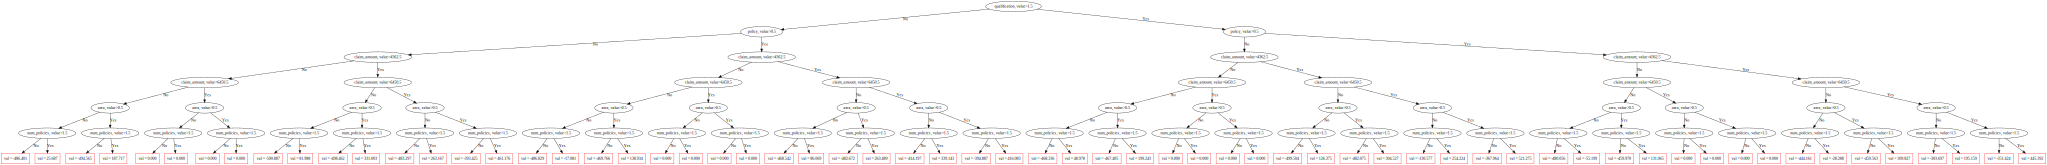

In [18]:
model.plot_tree(0, train_pool)

In [18]:
# Save file for submission
test_catboost[target] = model.predict(test_catboost[features])

submission = test_catboost.reset_index()[idx+[target]]

submission.to_csv(f'{DATA_DIR}/v{version}_cbr_{eval_metric}_{max_depth}_{early_stopping_rounds}_{learning_rate}-{rmse}_{mae}_{r2}.csv', index=False)

## XGBoost

In [19]:
import xgboost as xgb

version = 0.1
iterations = 10000
max_depth = 10
learning_rate = 0.04
eval_metric = 'R2'
early_stopping_rounds = 100
# l2_leaf_reg = 1

xgb_reg = xgb.XGBRegressor(
    # tree_method="hist",
    eval_metric=r2_score,
    # early_stopping_rounds=early_stopping_rounds,
    learning_rate=learning_rate,
    # max_depth=max_depth,
    # n_estimators=iterations
)
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])


[0]	validation_0-rmse:130636.40550	validation_0-r2_score:-1.05810
[1]	validation_0-rmse:127577.90379	validation_0-r2_score:-0.96286
[2]	validation_0-rmse:124693.18485	validation_0-r2_score:-0.87510
[3]	validation_0-rmse:121973.98588	validation_0-r2_score:-0.79421
[4]	validation_0-rmse:119414.32493	validation_0-r2_score:-0.71970
[5]	validation_0-rmse:117004.50426	validation_0-r2_score:-0.65099
[6]	validation_0-rmse:114735.87919	validation_0-r2_score:-0.58759
[7]	validation_0-rmse:112606.94833	validation_0-r2_score:-0.52922
[8]	validation_0-rmse:110607.72072	validation_0-r2_score:-0.47540
[9]	validation_0-rmse:108733.72728	validation_0-r2_score:-0.42583
[10]	validation_0-rmse:106975.28646	validation_0-r2_score:-0.38008
[11]	validation_0-rmse:105332.31629	validation_0-r2_score:-0.33802
[12]	validation_0-rmse:103790.67251	validation_0-r2_score:-0.29914
[13]	validation_0-rmse:102351.71419	validation_0-r2_score:-0.26337
[14]	validation_0-rmse:101005.34365	validation_0-r2_score:-0.23035
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=<function r2_score at 0x7fcebab0af70>, gamma=0,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.04, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [20]:
# Predict and Evaluate catboost model
y_pred = xgb_reg.predict(X_test[features])

print(f"-- v{version}")
r2, mae, rmse = get_regression_eval_metrics(y_test, y_pred)


-- v0.1
R^2 :  0.15835519638768092
MAE : 49371.470860541696
RMSE: 82065.41377911021


In [21]:
X_test.shape, test.shape

((17879, 11), (59595, 13))

In [23]:
# Save file for submission
test[target] = xgb_reg.predict(test[features])

submission = test.reset_index()[idx+[target]]

submission.to_csv(f'{DATA_DIR}/v{version}_xgb_{eval_metric}_{max_depth}_{early_stopping_rounds}_{learning_rate}-{rmse}_{mae}_{r2}.csv', index=False)


## Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

version = 0.1
iterations = 10000
max_depth = 10
learning_rate = 0.04
eval_metric = 'R2'
early_stopping_rounds = 100
# l2_leaf_reg = 1

rf_reg = RandomForestRegressor(
    # criterion="r2_score",
    random_state=42
)
rf_reg.fit(X_train, y_train[target].ravel())

rf_reg.predict(X_test)


array([135369.        ,  69065.88      ,  44589.78      , ...,
        41322.84      ,  71635.56      , 141953.76835613])

In [37]:
# Predict and Evaluate catboost model
y_pred = rf_reg.predict(X_test[features])

print(f"-- v{version}")
r2, mae, rmse = get_regression_eval_metrics(y_test, y_pred)


-- v0.1
R^2 :  0.0348692042327694
MAE : 54836.61801934018
RMSE: 87879.75290380493


## Ensemble

In [44]:
# Predict and Evaluate catboost model
y_pred = (model.predict(X_test[features]) + xgb_reg.predict(X_test[features]))/2

print(f"-- v{version}")
r2, mae, rmse = get_regression_eval_metrics(y_test, y_pred)


-- v0.1
R^2 :  0.15997775596481112
MAE : 49641.38518349969
RMSE: 81986.27097418834


In [45]:
version = 0.1

# Submission
test[target] = (model.predict(test_catboost[features]) + xgb_reg.predict(test[features]))/2

submission = test.reset_index()[idx+[target]]

submission.to_csv(f'{DATA_DIR}/v{version}_cbr_xgb.csv', index=False)
